In [1]:
import sys

sys.path.append('..')

from LoadData2 import loadNbackEmoidAgesScansAndGenders, loadMeta

pncDir = '../../PNC_Good'

keys, nbackTs, emoidTs, ages = loadNbackEmoidAgesScansAndGenders(loadMeta(f'{pncDir}/MegaMeta3.pkl'))

print(nbackTs.shape)
print(emoidTs.shape)
print(ages.shape)
print(ages[0:10])

(650, 264, 231)
(650, 264, 210)
(650,)
[ 9.66666667 15.58333333 15.83333333 20.16666667 11.41666667 11.58333333
  9.41666667 17.5        15.25        9.58333333]


In [2]:
# Get FC and convert to torch

from LoadData2 import getFC
import torch

nbackP = getFC(nbackTs)
emoidP = getFC(emoidTs)

nbackP_t = torch.from_numpy(nbackP).reshape(650,264*264).float().cuda()
emoidP_t = torch.from_numpy(emoidP).reshape(650,264*264).float().cuda()
feat_t = torch.cat([nbackP_t, emoidP_t], dim=1)
ages_t = torch.from_numpy(ages).float().cuda()

print(nbackP_t.shape)
print(emoidP_t.shape)
print(ages_t.shape)

torch.Size([650, 69696])
torch.Size([650, 69696])
torch.Size([650])


In [3]:
# Load model

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn.dense import DenseGCNConv

class GCN(nn.Module):
    def __init__(self):
        super(GCN, self).__init__()
        self.gc1 = DenseGCNConv(2*264*264,100).float().cuda()
        self.gc2 = DenseGCNConv(100,1).float().cuda()
        self.loss = nn.MSELoss()

    def forward(self, x):
        A = x[0]
        z = x[1]
        a = F.relu(self.gc1(z,A))
        a = self.gc2(a,A)
        return a

gcn = GCN()
gcn.load_state_dict(torch.load('../../Work/Explainer/GCN_NbackEmoid3.pyt'))
gcn.eval()

GCN(
  (gc1): DenseGCNConv(139392, 100)
  (gc2): DenseGCNConv(100, 1)
  (loss): MSELoss()
)

In [4]:
import functools

def getDataForAgeRange(ages, low, high):
    mask = torch.logical_and(ages > low, ages <= high)
    return torch.nonzero(mask, as_tuple=True), ages[mask]

ageBoundaries = [8,12,14,16,18,23]
ageIdcs = []
ageGrps = []

for i in range(len(ageBoundaries)-1):
    ai, ag = getDataForAgeRange(ages_t, ageBoundaries[i], ageBoundaries[i+1])
    ageIdcs.append(ai)
    ageGrps.append(ag)
    
print(functools.reduce(lambda n, grp: n+grp.shape[0], ageGrps, 0))

650


In [5]:
def normalize(A):
    if A.shape[0] != A.shape[1]:
        raise Exception("Bad A shape")
    d = torch.sum(A,dim=1)**0.5
    return ((A/d).T/d).T

# Cosine similarity

def cosineSim(a, b):
    nB = a.shape[0]
    e = torch.einsum('ai,bi->ab',a,b)
    aa = torch.einsum('ai,ai->a',a,a)**0.5
    bb = torch.einsum('bi,bi->b',b,b)**0.5
    e /= aa.unsqueeze(1)
    e /= bb.unsqueeze(1).T
    return normalize(e-torch.eye(nB).float().cuda())

A = cosineSim(feat_t, feat_t)

print(A.shape)

torch.Size([650, 650])


In [6]:
class Explainer(nn.Module):
    def __init__(self, nGroups):
        super(Explainer, self).__init__()
        self.fmasks = []
        self.Amasks = []
        for i in range(nGroups):
            self.fmasks.append(nn.Parameter(torch.ones(2*264*264).float().cuda()))
            self.Amasks.append(nn.Parameter(torch.ones(A.shape).float().cuda()))
        self.fmasks = nn.ParameterList(self.fmasks)
        self.Amasks = nn.ParameterList(self.Amasks)

    def forward(self, x):
        preds = []
        for i in range(len(self.groupIdcs)):
            fmask = torch.sigmoid(self.fmasks[i])
            Amask = torch.sigmoid(self.Amasks[i])
            preds.append(gcn([self.A*Amask, x*fmask]).flatten()[self.groupIdcs[i]])
        return preds

    def loss(self, preds, truths):
        fmasks = []
        Amasks = []
        loss = 0
        predLosses = []
        for fm, Am, pred, truth in zip(self.fmasks, self.Amasks, preds, truths):
            fm = torch.sigmoid(fm)
            Am = torch.sigmoid(Am)
            predLoss = gcn.loss(pred, truth)
            predLosses.append(predLoss)
            featSizeLoss = torch.mean(fm)
            featEntLoss = torch.mean(-fm*torch.log(fm) - (1-fm)*torch.log(1-fm))
            popSizeLoss = torch.mean(Am)
            popEntLoss = torch.mean(-Am*torch.log(Am) - (1-Am)*torch.log(1-Am))
            loss += self.HP['predl']*predLoss + self.HP['fsl']*featSizeLoss + self.HP['fel']*featEntLoss
            loss += self.HP['psl']*popSizeLoss + self.HP['pel']*popEntLoss
            fmasks.append(fm)
            Amasks.append(Am)
        for i in range(len(self.groupIdcs)):
            for j in range(i,len(self.groupIdcs)):
                featGroupConLoss = torch.mean(-fmasks[i]*torch.log(fmasks[j]) - (1-fmasks[i])*torch.log(1-fmasks[j]))
                popGroupConLoss = torch.mean(-Amasks[i]*torch.log(Amasks[j]) - (1-Amasks[i])*torch.log(1-Amasks[j]))
                loss += self.HP['fgcl']*featGroupConLoss + self.HP['pgcl']*popGroupConLoss
        return loss

exp = Explainer(5)
exp.load_state_dict(torch.load('../../Work/Explainer/ExpB_NoGroupLoss.pyt'))
exp.eval()

Explainer(
  (fmasks): ParameterList(
      (0): Parameter containing: [torch.cuda.FloatTensor of size 139392 (GPU 0)]
      (1): Parameter containing: [torch.cuda.FloatTensor of size 139392 (GPU 0)]
      (2): Parameter containing: [torch.cuda.FloatTensor of size 139392 (GPU 0)]
      (3): Parameter containing: [torch.cuda.FloatTensor of size 139392 (GPU 0)]
      (4): Parameter containing: [torch.cuda.FloatTensor of size 139392 (GPU 0)]
  )
  (Amasks): ParameterList(
      (0): Parameter containing: [torch.cuda.FloatTensor of size 650x650 (GPU 0)]
      (1): Parameter containing: [torch.cuda.FloatTensor of size 650x650 (GPU 0)]
      (2): Parameter containing: [torch.cuda.FloatTensor of size 650x650 (GPU 0)]
      (3): Parameter containing: [torch.cuda.FloatTensor of size 650x650 (GPU 0)]
      (4): Parameter containing: [torch.cuda.FloatTensor of size 650x650 (GPU 0)]
  )
)

In [7]:
nEpoch = 150
pPrint = 20

HP = {
    'predl': 1,
    'fsl': 3800,
    'fel': 20,
    'psl': 0,
    'pel': 1000,
    'fgcl': 1000,
    'pgcl': 0
}

exp = Explainer(5)
optim = torch.optim.Adam(exp.parameters(), lr=5e-1, weight_decay=0)

exp.A = A
exp.groupIdcs = ageIdcs
exp.HP = HP

for epoch in range(nEpoch):
    optim.zero_grad()
    preds = exp(feat_t)
    loss = exp.loss(preds, ageGrps)
    loss.backward()
    optim.step()
    if epoch % pPrint == 0 or epoch == nEpoch-1:
        print(f'epoch {epoch} loss={loss}')

print('Complete')

epoch 0 loss=25677.14453125
epoch 20 loss=6583.4296875
epoch 40 loss=2043.677734375
epoch 60 loss=1380.5853271484375
epoch 80 loss=1176.9840087890625
epoch 100 loss=1100.0543212890625
epoch 120 loss=1063.1165771484375
epoch 140 loss=1041.6976318359375
epoch 149 loss=1036.4434814453125
Complete


In [8]:
import numpy as np

roiMap1 = np.zeros(265,dtype='int')
roiMap2 = np.zeros(265,dtype='int')
revMap2 = np.zeros(264,dtype='int')
roiNames = {}
borders1 = []
borders2 = []

with open('../../PNC/PP264_template.csv', 'r') as f:
    lines = f.readlines()
    for i in range(2,len(lines)):
        line = lines[i].split(',')
        area = int(line[11])
        r1 = int(line[0])
        r2 = int(line[1])
        name = line[14].strip()
        roiMap1[r1] = area
        roiMap2[r2] = area
        roiNames[area] = name
        revMap2[r1-1] = r2-1
#         print([area, r1, r2, name])

last1 = roiMap1[1]
last2 = roiMap2[1]
for i in range(2,265):
    if roiMap1[i] != last1:
        borders1.append(i)
        last1 = roiMap1[i]
    if roiMap2[i] != last2:
        borders2.append(i)
        last2 = roiMap2[i]
    
borders1 = [0] + borders1 + [264]
print(borders1)
print(borders2)

[0, 31, 36, 50, 63, 121, 126, 157, 182, 200, 213, 222, 233, 237, 264]
[13, 42, 47, 61, 74, 84, 86, 132, 133, 137, 138, 139, 140, 143, 174, 182, 186, 203, 221, 222, 235, 243, 247, 251, 253, 255, 256]


/home/anton/.conda/envs/torch/lib/python3.7/site-packages/ipykernel_launcher.py:61: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.


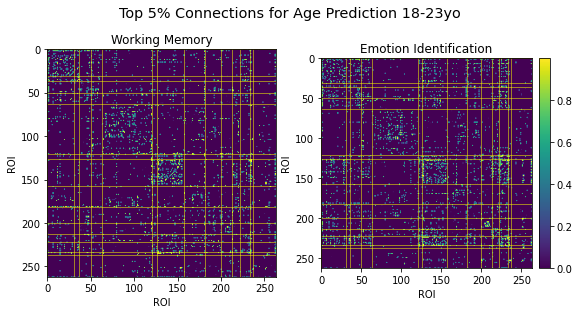

In [9]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

def quantile(mask, q):
    msk = torch.sigmoid(mask).reshape(264,264)
    mskq = torch.quantile(msk, q)
    msk[msk < mskq] = 0
    msk[msk >= mskq] = 1
    return msk

def maskDiag(A):
    if A.ndim != 2 or A.shape[0] != A.shape[1]:
        raise Exception('bad A shape')
    return A*(1-np.eye(A.shape[0]))

def rearrange(p,idcs):
    return p[:,idcs][idcs]

def displayMask(exp, fA, i, title, q=None, saveFile=None):
    if fA == 'f':
        if q:
            nm = quantile(exp.fmasks[i][:264*264], q).detach().cpu().numpy()
            em = quantile(exp.fmasks[i][264*264:], q).detach().cpu().numpy()
        else:
            nm = torch.sigmoid(exp.fmasks[i][:264*264]).reshape(264,264).detach().cpu().numpy()
            em = torch.sigmoid(exp.fmasks[i][264*264:]).reshape(264,264).detach().cpu().numpy()
        
        fig, ax = plt.subplots(1,2,figsize=(9,4.2))
        fig.suptitle(title, y=1.02, fontsize='x-large')
        
        color = 'yellow'
        
        im1 = ax[0].imshow(rearrange(maskDiag(nm), revMap2))
        for b in borders1:
            ax[0].plot([0,263],[b,b],color=color,linewidth=0.5)
            ax[0].plot([b,b],[0,263],color=color,linewidth=0.5)
        ax[0].set_ylabel('ROI')
        ax[0].set_xlabel('ROI')
        ax[0].set_title(f'Working Memory')
        ax[0].set_xlim(0,263)
        ax[0].set_ylim(262,0)

        if not q:
            divider = make_axes_locatable(ax[1])
            cax2 = divider.append_axes('right', size='5%', pad=0.1)

        im2 = ax[1].imshow(rearrange(maskDiag(em), revMap2))
        for b in borders1:
            ax[1].plot([0,263],[b,b],color=color,linewidth=0.5)
            ax[1].plot([b,b],[0,263],color=color,linewidth=0.5)
        ax[1].set_ylabel('ROI')
        ax[1].set_xlabel('ROI')
        ax[1].set_title('Emotion Identification')
        ax[1].set_xlim(0,263)
        ax[1].set_ylim(262,0)

        # fig.colorbar(im1, cax=cax1, orientation='vertical')
        if not q:
            fig.colorbar(im2, cax=cax2, orientation='vertical')

        fig.show()
        if saveFile:
            fig.savefig(saveFile, format='png', bbox_inches='tight')
        
    if fA == 'A':
        m = exp.Amasks[i] 
        m = torch.sigmoid(m).detach().cpu().numpy()
        
        plt.imshow(m)
        plt.colorbar()
        plt.title('Population')
        plt.show()
    
displayMask(exp, 'f', 4, 'Top 5% Connections for Age Prediction 18-23yo')#, 0.95, 
#             '../../Work/Explainer/Top5_4_NoGroupLoss.png')

/home/anton/.conda/envs/torch/lib/python3.7/site-packages/ipykernel_launcher.py:56: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.


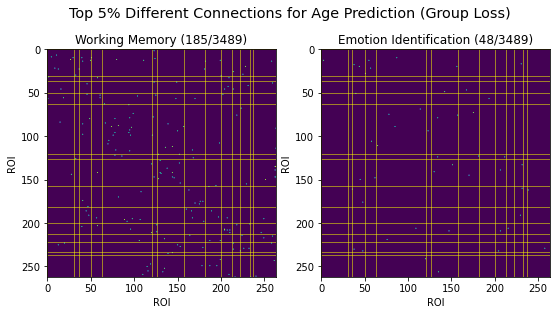

In [76]:
nm = torch.ones(264,264).float().cuda()
em = torch.ones(264,264).float().cuda()

nmd = torch.zeros(264,264).float().cuda()
emd = torch.zeros(264,264).float().cuda()

q = 0.95

for i in range(5):
    nm *= quantile(exp.fmasks[i][:264*264], q)
    em *= quantile(exp.fmasks[i][264*264:], q)
    
    nmd += quantile(exp.fmasks[i][:264*264], q)
    emd += quantile(exp.fmasks[i][264*264:], q)
    
nmd[nmd > 0] = 1
emd[emd > 0] = 1

nmd *= (1-nm)
emd *= (1-em)
    
nm = maskDiag(nmd.detach().cpu().numpy())
em = maskDiag(emd.detach().cpu().numpy())
    
fig, ax = plt.subplots(1,2,figsize=(9,4.2))
fig.suptitle('Top 5% Different Connections for Age Prediction (Group Loss)', y=1.02, fontsize='x-large')

color = 'yellow'

im1 = ax[0].imshow(rearrange(nm, revMap2))
for b in borders1:
    ax[0].plot([0,263],[b,b],color=color,linewidth=0.5)
    ax[0].plot([b,b],[0,263],color=color,linewidth=0.5)
ax[0].set_ylabel('ROI')
ax[0].set_xlabel('ROI')
ax[0].set_title(f'Working Memory ({int(np.sum(nm))}/3489)')
ax[0].set_xlim(0,263)
ax[0].set_ylim(262,0)

# divider = make_axes_locatable(ax[1])
# cax2 = divider.append_axes('right', size='5%', pad=0.1)

im2 = ax[1].imshow(rearrange(em, revMap2))
for b in borders1:
    ax[1].plot([0,263],[b,b],color=color,linewidth=0.5)
    ax[1].plot([b,b],[0,263],color=color,linewidth=0.5)
ax[1].set_ylabel('ROI')
ax[1].set_xlabel('ROI')
ax[1].set_title(f'Emotion Identification ({int(np.sum(em))}/3489)')
ax[1].set_xlim(0,263)
ax[1].set_ylim(262,0)

# fig.colorbar(im1, cax=cax1, orientation='vertical')
# fig.colorbar(im2, cax=cax2, orientation='vertical')

fig.show()
fig.savefig('../../Work/Explainer/Top5_Diff_GroupLoss.png', format='png', bbox_inches='tight')


In [10]:
rawpred = gcn([A, feat_t]).flatten()
for grp in range(5):
    print(gcn.loss(rawpred[ageIdcs[grp]], ageGrps[grp])**0.5)

preds = exp(feat_t)
loss = exp.loss(preds, ageGrps)
    
for grp in range(5):
    print(gcn.loss(preds[grp], ageGrps[grp])**0.5)

tensor(1.0206, device='cuda:0', grad_fn=<PowBackward0>)
tensor(0.7883, device='cuda:0', grad_fn=<PowBackward0>)
tensor(0.6702, device='cuda:0', grad_fn=<PowBackward0>)
tensor(0.7371, device='cuda:0', grad_fn=<PowBackward0>)
tensor(1.1528, device='cuda:0', grad_fn=<PowBackward0>)
tensor(5.1629, device='cuda:0', grad_fn=<PowBackward0>)
tensor(3.2600, device='cuda:0', grad_fn=<PowBackward0>)
tensor(1.5440, device='cuda:0', grad_fn=<PowBackward0>)
tensor(1.2186, device='cuda:0', grad_fn=<PowBackward0>)
tensor(3.1953, device='cuda:0', grad_fn=<PowBackward0>)


In [93]:
for i in range(5):
    nm_t = torch.from_numpy(nm[i]+np.eye(264)).float().cuda()
    em_t = torch.from_numpy(em[i]+np.eye(264)).float().cuda()
    mask = torch.cat([nm_t.reshape(-1), em_t.reshape(-1)]).unsqueeze(0).expand(650,2*264*264)
    pred = gcn([A, feat_t*mask]).flatten()
    print(gcn.loss(pred[ageIdcs[i]], ages_t[ageIdcs[i]])**0.5)

tensor(4.4342, device='cuda:0', grad_fn=<PowBackward0>)
tensor(4.4205, device='cuda:0', grad_fn=<PowBackward0>)
tensor(7.6828, device='cuda:0', grad_fn=<PowBackward0>)
tensor(8.0333, device='cuda:0', grad_fn=<PowBackward0>)
tensor(11.6979, device='cuda:0', grad_fn=<PowBackward0>)


In [90]:
print(mask.shape)
print(feat_t.shape)

torch.Size([804, 139392])
torch.Size([650, 139392])


In [15]:
rawpred = gcn([A, feat_t]).flatten()
gcn.loss(rawpred, ages_t)

tensor(1.6637, device='cuda:0', grad_fn=<MseLossBackward0>)

In [11]:
# Save the explainer masks

torch.save(exp.state_dict(), "../../Work/Explainer/ExpB_GroupLoss.pyt")

/home/anton/.conda/envs/torch/lib/python3.7/site-packages/ipykernel_launcher.py:32: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.


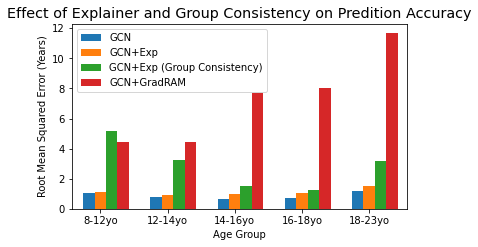

In [1]:
import matplotlib.pyplot as plt
import numpy as np

ind = np.arange(1,6)
width = 0.17

orig = (1.0206, 0.7883, 0.6702, 0.7371, 1.1528)
noGroupLoss = (1.1205, 0.8998, 0.997, 1.0183, 1.5181)
groupLoss = (5.1629, 3.26, 1.544, 1.2186, 3.1953)
gradRam = (4.4342, 4.4205, 7.6828, 8.0333, 11.6979)

fig, ax = plt.subplots(figsize=(6,3.4))

ax.bar(ind, orig, width, label='GCN')
ax.bar(ind + width, noGroupLoss, width, label='GCN+Exp')
ax.bar(ind + 2*width, groupLoss, width, label='GCN+Exp (Group Consistency)')
ax.bar(ind + 3*width, gradRam, width, label='GCN+GradRAM')

ax.set_ylabel('Root Mean Squared Error (Years)')
ax.set_title('Effect of Explainer and Group Consistency on Predition Accuracy', fontsize='x-large')

ax.set_xticks(ind + width)
ax.set_xticklabels(('8-12yo', '12-14yo', '14-16yo', '16-18yo', '18-23yo'))
# ax[0].legend(loc='lower right')
ax.set_xlim(0.75,5.73)

ax.legend()
ax.set_xlabel('Age Group')
# ax[0].legend(loc='lower right')

# fig.suptitle('Age Prediction', y=0.95, fontsize='x-large')
fig.show()
fig.savefig('../../Work/Explainer/ExplainerPredictionAccuracyGradGAM.png', format='png', bbox_inches='tight')

In [55]:
def getTopSystems(binfc, n):
    L = int(15*14/2)
    keys = np.zeros([L,2])
    vals = np.zeros(L)
    idx = 0
    for i in range(14):
        i0 = borders1[i]
        i1 = borders1[i+1]
        for j in range(i,14):
            j0 = borders1[j]
            j1 = borders1[j+1]
            s = np.sum(binfc[i0:i1,j0:j1])
            keys[idx][0] = i
            keys[idx][1] = j
            vals[idx] = s
            idx += 1
    idcs = np.argsort(vals)
    return keys[idcs][::-1,:][0:n,:], vals[idcs][::-1][0:n]

def prettyPrintSystems(sysRes, title):
    lookup = ["SM Hand", "SM Mouth", "CNG", "AUD", "DMN", "MEM", "VIS", "FRNT", "SAL", "SUB", "VTRL", "DRSL", "CB", "UNK"]
    keys = sysRes[0].astype(int)
    vals = sysRes[1].astype(int)
    print(title)
    for i in range(keys.shape[0]):
        print(f'{lookup[keys[i,0]]}-{lookup[keys[i,1]]} {vals[i]}')

ageLabels = ["8-12", "12-14", "14-16", "16-18", "18-22"]

for i in range(5):
    prettyPrintSystems(getTopSystems(quantile(exp.fmasks[i][:264*264], q).detach().cpu().numpy(), 5), 
    f"nback Age Prediction GCN+Explainer {ageLabels[i]}")
    
for i in range(5):
    prettyPrintSystems(getTopSystems(quantile(exp.fmasks[i][264*264:], q).detach().cpu().numpy(), 5), 
    f"emoid Age Prediction GCN+Explainer {ageLabels[i]}")

nback Age Prediction GCN+Explainer 8-12
DMN-DMN 299
VIS-VIS 118
UNK-UNK 94
FRNT-FRNT 86
VIS-FRNT 80
nback Age Prediction GCN+Explainer 12-14
DMN-DMN 313
VIS-VIS 121
UNK-UNK 112
FRNT-FRNT 96
VIS-FRNT 86
nback Age Prediction GCN+Explainer 14-16
DMN-DMN 314
VIS-VIS 119
UNK-UNK 112
FRNT-FRNT 90
SM Hand-SM Hand 87
nback Age Prediction GCN+Explainer 16-18
DMN-DMN 327
VIS-VIS 123
UNK-UNK 109
SM Hand-SM Hand 88
VIS-FRNT 87
nback Age Prediction GCN+Explainer 18-22
DMN-DMN 334
VIS-VIS 118
UNK-UNK 117
SM Hand-SM Hand 91
VIS-FRNT 89
emoid Age Prediction GCN+Explainer 8-12
DMN-DMN 248
VIS-VIS 153
UNK-UNK 124
VIS-UNK 102
FRNT-FRNT 76
emoid Age Prediction GCN+Explainer 12-14
DMN-DMN 255
VIS-VIS 145
UNK-UNK 142
VIS-UNK 113
FRNT-FRNT 81
emoid Age Prediction GCN+Explainer 14-16
DMN-DMN 272
VIS-VIS 145
UNK-UNK 141
VIS-UNK 117
FRNT-FRNT 85
emoid Age Prediction GCN+Explainer 16-18
DMN-DMN 272
UNK-UNK 144
VIS-VIS 139
VIS-UNK 121
FRNT-FRNT 86
emoid Age Prediction GCN+Explainer 18-22
DMN-DMN 275
UNK-UNK 151
V

In [202]:
gcn.zero_grad()
pred = gcn([A, feat_t]).flatten()
loss = gcn.loss(pred[ageIdcs[i]], ages_t[ageIdcs[i]])
loss.backward()
print(gcn.gc2.lin.weight.grad)

tensor([[ -6.0751,   0.0000,   0.0000,  -1.5769,  -6.4149,  -2.3284,  -6.1471,
         -10.9467,  -5.1922,   0.0000,  -9.0202,  -6.7300,   0.0000,  -9.8347,
           0.0000,   0.0000,  -9.4215,   0.0000,  -5.2248,   0.0000,  -2.3255,
           0.0000,   0.0000,  -9.1540,  -3.6732,  -4.6746,   0.0000,   0.0000,
          -8.7810,   0.0000,  -4.8269,   0.0000,   0.0000,  -3.2738,  -2.6767,
           0.0000, -10.3592,  -9.7242,  -9.2284,  -9.3501,   0.0000,   0.0000,
           0.0000,  -4.3558,  -7.8880,   0.0000, -10.8857,  -8.0917,   0.0000,
           0.0000,  -6.5959,  -6.6295,  -2.2939,   0.0000,  -8.9604,  -3.5351,
           0.0000,  -1.6338,  -3.1664,   0.0000,  -7.2282,   0.0000,  -2.0151,
          -2.3231, -10.0019,  -9.7095,  -4.5283,  -5.7819,   0.0000,   0.0000,
          -5.4604,   0.0000,   0.0000,  -8.0980,  -9.2845,  -0.5103,   0.0000,
          -9.3498,   0.0000,  -6.9504,  -6.8900,   0.0000,  -9.7236,   0.0000,
           0.0000,  -8.8263,  -0.5602,   0.0000,  -9

In [53]:
gcn.zero_grad()
pred = gcn([A, feat_t]).flatten()
loss = gcn.loss(pred[ages_t > 16], ages_t[ages_t > 16])
loss.backward()
ram = (gcn.gc2.lin.weight.grad@gcn.gc1.lin.weight).flatten()

pred = gcn([A, feat_t*ram.unsqueeze(0)]).flatten()
print(gcn.loss(pred, ages_t))

tensor(558.3832, device='cuda:0', grad_fn=<MseLossBackward0>)


/home/anton/.conda/envs/torch/lib/python3.7/site-packages/ipykernel_launcher.py:35: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.


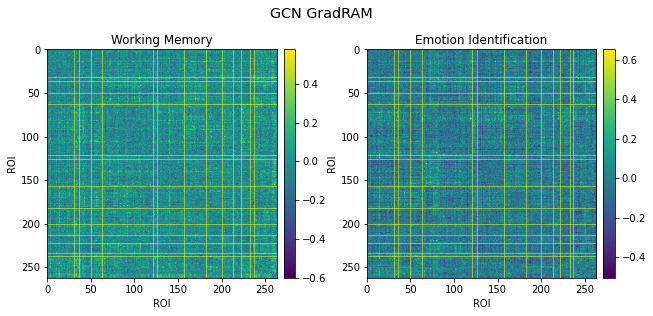

In [79]:


fig, ax = plt.subplots(1,2,figsize=(10.5,4.2))
fig.suptitle('GCN GradRAM', y=1.02, fontsize='x-large')

color = 'yellow'

divider = make_axes_locatable(ax[0])
cax1 = divider.append_axes('right', size='5%', pad=0.1)

im1 = ax[0].imshow(rearrange(ram[:264*264].reshape(264,264).detach().cpu().numpy(), revMap2))
for b in borders1:
    ax[0].plot([0,263],[b,b],color=color,linewidth=0.5)
    ax[0].plot([b,b],[0,263],color=color,linewidth=0.5)
ax[0].set_ylabel('ROI')
ax[0].set_xlabel('ROI')
ax[0].set_title(f'Working Memory')
ax[0].set_xlim(0,263)
ax[0].set_ylim(262,0)

divider = make_axes_locatable(ax[1])
cax2 = divider.append_axes('right', size='5%', pad=0.1)

im2 = ax[1].imshow(rearrange(ram[264*264:].reshape(264,264).detach().cpu().numpy(), revMap2))
for b in borders1:
    ax[1].plot([0,263],[b,b],color=color,linewidth=0.5)
    ax[1].plot([b,b],[0,263],color=color,linewidth=0.5)
ax[1].set_ylabel('ROI')
ax[1].set_xlabel('ROI')
ax[1].set_title(f'Emotion Identification')
ax[1].set_xlim(0,263)
ax[1].set_ylim(262,0)

fig.colorbar(im1, cax=cax1, orientation='vertical')
fig.colorbar(im2, cax=cax2, orientation='vertical')

fig.show()
fig.savefig('../../Work/Explainer/GradRAM.png', format='png', bbox_inches='tight')

In [80]:
idx = 0

nm = []
em = []

for i in range(5):
    gcn.zero_grad()
    pred = gcn([A, feat_t]).flatten()
    loss = gcn.loss(pred[ageIdcs[i]], ages_t[ageIdcs[i]])
    loss.backward()
    ram = torch.abs(gcn.gc2.lin.weight.grad@gcn.gc1.lin.weight).flatten()

    nm.append(quantile(ram[:264*264], 0.95).reshape(264,264).detach().cpu().numpy())
    em.append(quantile(ram[264*264:], 0.95).reshape(264,264).detach().cpu().numpy())

In [81]:
print(ram.shape)

torch.Size([139392])


In [85]:
nmcommon = np.ones([264,264])
emcommon = np.ones([264,264])

for i in range(1,5):
    nmcommon *= nm[i]
    emcommon *= em[i]

/home/anton/.conda/envs/torch/lib/python3.7/site-packages/ipykernel_launcher.py:32: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.


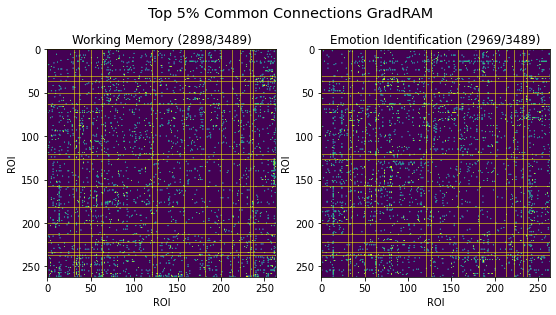

In [86]:
fig, ax = plt.subplots(1,2,figsize=(9,4.2))
fig.suptitle('Top 5% Common Connections GradRAM', y=1.02, fontsize='x-large')

color = 'yellow'

im1 = ax[0].imshow(rearrange(nmcommon, revMap2))
for b in borders1:
    ax[0].plot([0,263],[b,b],color=color,linewidth=0.5)
    ax[0].plot([b,b],[0,263],color=color,linewidth=0.5)
ax[0].set_ylabel('ROI')
ax[0].set_xlabel('ROI')
ax[0].set_title(f'Working Memory ({int(np.sum(nmcommon))}/3489)')
ax[0].set_xlim(0,263)
ax[0].set_ylim(262,0)

# divider = make_axes_locatable(ax[1])
# cax2 = divider.append_axes('right', size='5%', pad=0.1)

im2 = ax[1].imshow(rearrange(emcommon, revMap2))
for b in borders1:
    ax[1].plot([0,263],[b,b],color=color,linewidth=0.5)
    ax[1].plot([b,b],[0,263],color=color,linewidth=0.5)
ax[1].set_ylabel('ROI')
ax[1].set_xlabel('ROI')
ax[1].set_title(f'Emotion Identification ({int(np.sum(emcommon))}/3489)')
ax[1].set_xlim(0,263)
ax[1].set_ylim(262,0)

# fig.colorbar(im1, cax=cax1, orientation='vertical')
# fig.colorbar(im2, cax=cax2, orientation='vertical')

fig.show()
fig.savefig('../../Work/Explainer/GradRam_Common.png', format='png', bbox_inches='tight')

In [89]:
print(nm[0].shape)

(264, 264)
